# Imports

In [1]:
from s_hac import SurvivalHierarchicalAgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter

# Create Simulated Data

In [2]:
def gen_surv(hazard_rate, censoring_rate, max_t):
    # Generates randomized survival data
    for t in range(max_t + 1):
        rand_hazard = np.random.uniform()
        rand_censor = np.random.uniform()

        if rand_hazard <= hazard_rate:
            return [t, 1]
        if rand_censor <= censoring_rate:
            return [t, 0]
    
    return [max_t, 0]

In [3]:
np.random.seed(1)

n_patients = 1250

x = np.random.normal(loc=0, scale=1, size=(n_patients, 1))
y = np.random.normal(loc=0, scale=1, size=(n_patients, 1))
c = [1 if x_ < 1 and x_ > -1 else 2 if x_>= 1 else 3 for x_ in x]
surv = [gen_surv(0.1/(c_**3), 0.01, 100) for c_ in c]

npdf = np.concatenate((x, y, np.array(surv), np.array(c).reshape(-1,1)), axis=1)
df = pd.DataFrame(npdf, columns=['x', 'y','T', 'E', 'Cluster'])

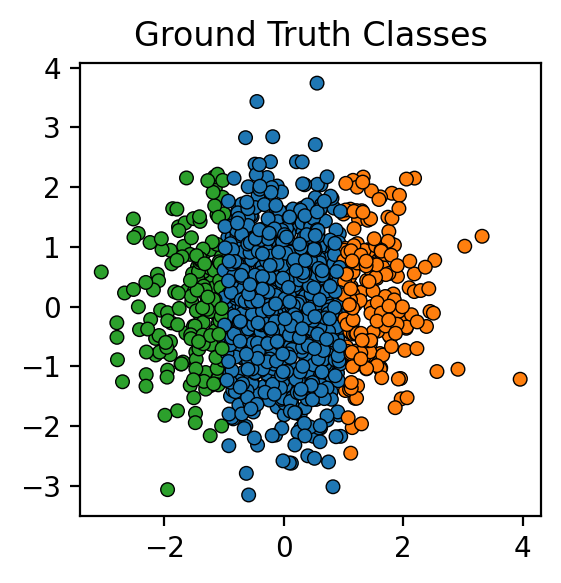

In [4]:
# Show Covariate Space
fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal', 'box')
ax.scatter(x, y, c=[['tab:blue', 'tab:orange', 'tab:green'][c_-1] for c_ in c], s=24, 
            edgecolors="black", 
            linewidth=0.5)
plt.title('Ground Truth Classes')
plt.show()

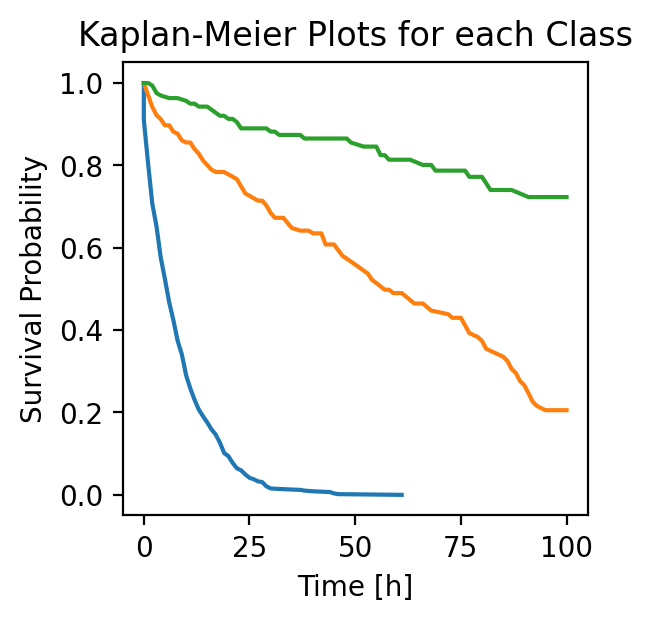

In [5]:
# Show Kaplan Meier Curves
kmf = KaplanMeierFitter() #(alpha=0.999999)
fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(111)

cmaps = ['tab:blue', 'tab:orange', 'tab:green']

for i, (name, grouped_df) in enumerate(df.groupby('Cluster')):
    kmf.fit(grouped_df["T"]+0.001, grouped_df["E"], label=name)
    plt.plot(kmf.survival_function_)
    plt.xlabel('Time [h]')
    plt.ylabel('Survival Probability')

plt.title('Kaplan-Meier Plots for each Class')
plt.show()

# Fit and predict with S-HAC

In [6]:
shac = SurvivalHierarchicalAgglomerativeClustering(n_neighbors=90,
                                                   alpha=0.5,
                                                   min_cluster_size=90,
                                                   logrank_p_threshold=0.05)

cluster_assignments = shac.fit_predict(X=np.array(df.loc[:, ['x', 'y']]), 
                                       lifetimes=[np.array(surv)])

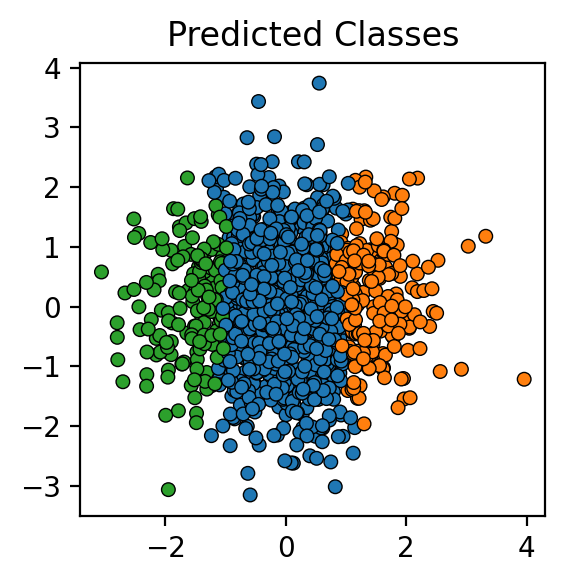

In [7]:
# Show result
plt.figure(figsize=(3,3), dpi=200)
plt.scatter(np.array(df.loc[:, ['x', 'y']])[:, 0], 
            np.array(df.loc[:, ['x', 'y']])[:, 1], 
            c=[['tab:blue', 'tab:green', 'tab:orange'][c_] for c_ in cluster_assignments],
            s=24,
            edgecolors="black", 
            linewidth=0.5)
plt.title('Predicted Classes')
plt.show()